In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests

# Load Data

### HDB data

In [3]:
clean_hdb_df1 = pd.read_csv('Processed_Data/hdb_data_with_coords_mrt_dist_id.csv',
    parse_dates=['month', 'lease_commence_date'])

hdb_df = clean_hdb_df1.copy()

### Car COE data

In [4]:
car_df=pd.read_csv('COE_Car_data/Results of COE Bidding Exercise - Results.csv',
    parse_dates=['Announcement Date', 'Year'])

car_coe_df=car_df.copy()


In [5]:
car_coe_df

,Bidding Exercise,Announcement Date,Year,Category,Quota,Quota Premium,Total Bids Received,Number of Successful Bids
0,October 2025 First Open Bidding Exercise,08/10/2025,2025-01-01,Cat A (Cars up to 1600cc and 97kW),1268,"$128,105",2572,1239
1,October 2025 First Open Bidding Exercise,08/10/2025,2025-01-01,Cat B (Cars above 1600cc or 97kW),830,"$141,000",1202,828
2,October 2025 First Open Bidding Exercise,08/10/2025,2025-01-01,Cat C (Goods vehicles and buses),274,"$74,301",424,273
3,October 2025 First Open Bidding Exercise,08/10/2025,2025-01-01,Cat D (Motorcycles),533,"$9,810",630,528
4,October 2025 First Open Bidding Exercise,08/10/2025,2025-01-01,Cat E (Open),259,"$140,009",472,251
...,...,...,...,...,...,...,...,...
2790,December 2002 Second Open Bidding Exercise,15/12/2002,2002-01-01,Cat A (Cars up to 1600cc and 97kW),"1,338","$26,993","1,546","1,337"
2791,December 2002 Second Open Bidding Exercise,15/12/2002,2002-01-01,Cat B (Cars above 1600cc or 97kW),728,"$23,890",977,728
2792,December 2002 Second Open Bidding Exercise,15/12/2002,2002-01-01,Cat C (Goods vehicles and buses),579,"$10,001",682,544
2793,December 2002 Second Open Bidding Exercise,15/12/2002,2002-01-01,Cat D (Motorcycles),991,$1,734,734


# Cleaning car COE data

In [6]:
# Remove '$' and ',' from 'Quota Premium' and convert to float
# Convert to string first, then remove $ and commas, then convert to float
car_coe_df['Quota Premium'] = car_coe_df['Quota Premium'].astype(str).str.replace('[$,]', '', regex=True).astype(float)

# Remove commas from numeric columns before conversion
for col in ['Quota', 'Total Bids Received', 'Number of Successful Bids']:
    car_coe_df[col] = car_coe_df[col].str.replace(',', '', regex=True).astype(int)

# Convert 'Announcement Date' to datetime
car_coe_df['Announcement Date'] = pd.to_datetime(car_coe_df['Announcement Date'], format='%d/%m/%Y', errors='coerce')

# Ensure string types for categorical columns
car_coe_df['Bidding Exercise'] = car_coe_df['Bidding Exercise'].astype(str)
car_coe_df['Category'] = car_coe_df['Category'].astype(str)

# Check datatypes
print(car_coe_df.dtypes)

car_coe_df.to_csv('COE_Car_data/car_coe_df.csv', index=False)



Bidding Exercise                     object
Announcement Date            datetime64[ns]
Year                         datetime64[ns]
Category                             object
Quota                                 int64
Quota Premium                       float64
Total Bids Received                   int64
Number of Successful Bids             int64
dtype: object


In [7]:
car_coe_df.columns

Index(['Bidding Exercise', 'Announcement Date', 'Year', 'Category', 'Quota',
       'Quota Premium', 'Total Bids Received', 'Number of Successful Bids'],
      dtype='object')

In [8]:
hdb_df.columns

Index(['remaining_lease', 'floor_area_sqm', 'storey_range', 'street_name',
       'lease_commence_date', 'month', 'flat_type', 'resale_price', 'town',
       'block', 'flat_model', 'storey_range_min', 'storey_range_max',
       'full_address', 'Latitude', 'Longitude', 'nearest_mrt_id', 'mrt_name',
       'mrt_latitude', 'mrt_longitude', 'mrt_road', 'Distance_from_MRT_km',
       'transaction_id'],
      dtype='object')

In [9]:
set(car_coe_df['Category'])

{'Cat A (Cars up to 1600cc and 97kW)',
 'Cat B (Cars above 1600cc or 97kW)',
 'Cat C (Goods vehicles and buses)',
 'Cat D (Motorcycles)',
 'Cat E (Open)'}

In [10]:
# Filter COE data for relevant categories
filtered_coe = car_coe_df[car_coe_df['Category'].isin([
    'Cat A (Cars up to 1600cc and 97kW)',
    'Cat B (Cars above 1600cc or 97kW)'
])]

In [11]:
set(hdb_df['town'])

{'ANG MO KIO',
 'BEDOK',
 'BISHAN',
 'BUKIT BATOK',
 'BUKIT MERAH',
 'BUKIT PANJANG',
 'BUKIT TIMAH',
 'CENTRAL AREA',
 'CHOA CHU KANG',
 'CLEMENTI',
 'GEYLANG',
 'HOUGANG',
 'JURONG EAST',
 'JURONG WEST',
 'KALLANG/WHAMPOA',
 'LIM CHU KANG',
 'MARINE PARADE',
 'PASIR RIS',
 'PUNGGOL',
 'QUEENSTOWN',
 'SEMBAWANG',
 'SENGKANG',
 'SERANGOON',
 'TAMPINES',
 'TOA PAYOH',
 'WOODLANDS',
 'YISHUN'}

# Visualizing HDB pricing and COE pricing trends with time

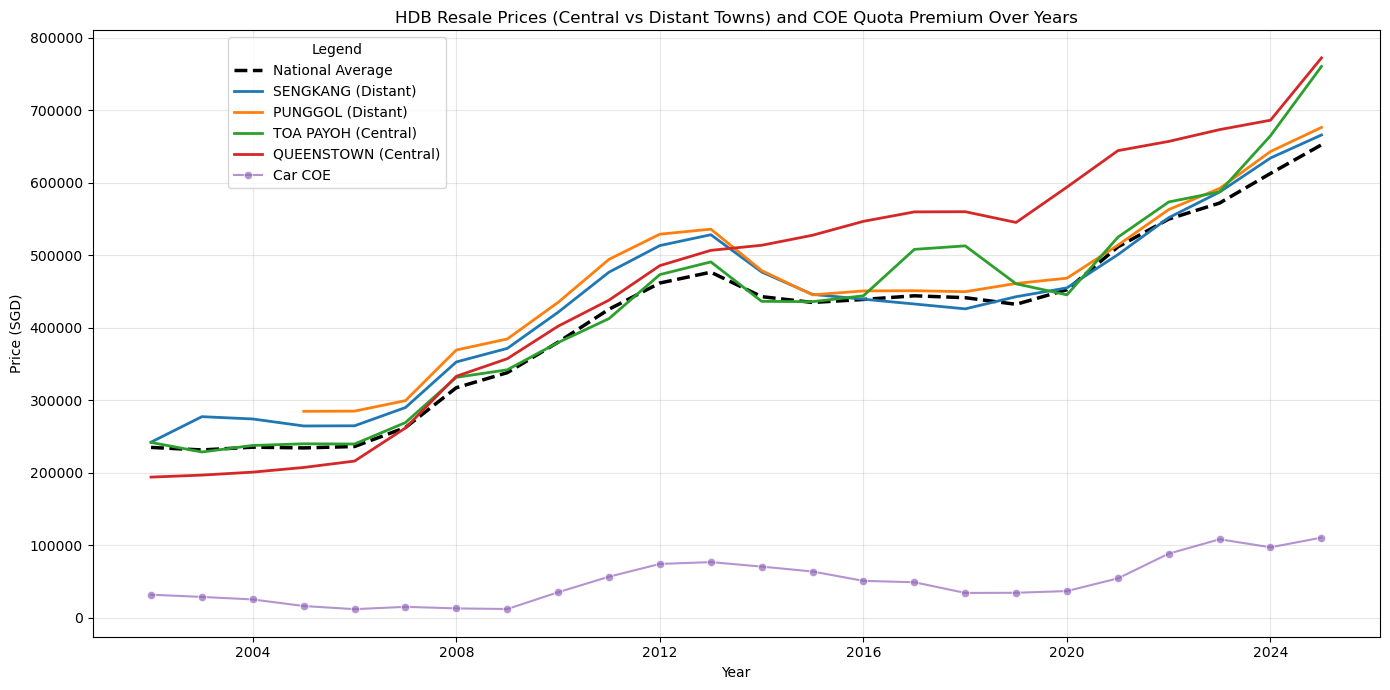

In [12]:
# Aggregate average Quota Premium by year and category
#coe_avg = filtered_coe.groupby(['Year', 'Category'])['Quota Premium'].mean().reset_index()
# Aggregate average Quota Premium by year (combining Cat A and B)
coe_avg = filtered_coe.groupby('Year')['Quota Premium'].mean().reset_index()

# Aggregate average resale price by year from hdb_df
hdb_df['Year'] = pd.to_datetime(hdb_df['month']).dt.to_period('Y').dt.start_time
hdb_avg = hdb_df.groupby('Year')['resale_price'].mean().reset_index()

# Aggregate average resale price for Sengkang and Punggol (distant towns)
sengkang_avg = hdb_df[hdb_df['town'] == 'SENGKANG'].groupby('Year')['resale_price'].mean().reset_index()
sengkang_avg['Town'] = 'SENGKANG'

punggol_avg = hdb_df[hdb_df['town'] == 'PUNGGOL'].groupby('Year')['resale_price'].mean().reset_index()
punggol_avg['Town'] = 'PUNGGOL'

# Aggregate average resale price for Toa Payoh and Queenstown (central towns)
toa_payoh_avg = hdb_df[hdb_df['town'] == 'TOA PAYOH'].groupby('Year')['resale_price'].mean().reset_index()
toa_payoh_avg['Town'] = 'TOA PAYOH'

queenstown_avg = hdb_df[hdb_df['town'] == 'QUEENSTOWN'].groupby('Year')['resale_price'].mean().reset_index()
queenstown_avg['Town'] = 'QUEENSTOWN'

# Filter HDB data to start from the first year in car COE data (2002)
start_year = coe_avg['Year'].min()
hdb_avg = hdb_avg[hdb_avg['Year'] >= start_year]
sengkang_avg = sengkang_avg[sengkang_avg['Year'] >= start_year]
punggol_avg = punggol_avg[punggol_avg['Year'] >= start_year]
toa_payoh_avg = toa_payoh_avg[toa_payoh_avg['Year'] >= start_year]
queenstown_avg = queenstown_avg[queenstown_avg['Year'] >= start_year]

# Plotting
plt.figure(figsize=(14, 7))

# Plot average resale price over years
sns.lineplot(data=hdb_avg, x='Year', y='resale_price', label='National Average', linewidth=2.5, color='black', linestyle='--')

# Distant towns
sns.lineplot(data=sengkang_avg, x='Year', y='resale_price', label='SENGKANG (Distant)', linewidth=2)
sns.lineplot(data=punggol_avg, x='Year', y='resale_price', label='PUNGGOL (Distant)', linewidth=2)

# Central towns
sns.lineplot(data=toa_payoh_avg, x='Year', y='resale_price', label='TOA PAYOH (Central)', linewidth=2)
sns.lineplot(data=queenstown_avg, x='Year', y='resale_price', label='QUEENSTOWN (Central)', linewidth=2)

# Plot COE Quota Premium by category over years
sns.lineplot(data=coe_avg, x='Year', y='Quota Premium', marker='o', alpha=0.7, label='Car COE') # hue='Category',

plt.title('HDB Resale Prices (Central vs Distant Towns) and COE Quota Premium Over Years')
plt.xlabel('Year')
plt.ylabel('Price (SGD)')
plt.legend(title='Legend', bbox_to_anchor=(0.1, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("figures/hdb_prices_vs_car_coe.pdf", dpi=300, bbox_inches='tight')
plt.show()

### Thoughts

If people were substituting distant flats for cars, we would expect:

- Distant town prices to rise when COE is high (increased demand)
- Central town prices to fall or grow slower (decreased demand)
data shows the opposite - central towns appreciate faster

Possible Explanations:
A. Wealth Effect Dominates

High COE periods often coincide with economic booms
Wealthier households can afford both expensive flats and expensive cars
They prefer central locations (better amenities, prestige, convenience)
Result: Central town prices surge more during prosperous times

B. Car Ownership May Not Drive Location Choice

People buying in distant towns might do so because:
- They can not afford central areas (budget constraint)
- They are first-time buyers
- Family expansion needs

Not primarily to save money for a car

Conclusion:

There is no strong evidence that COE prices impact distant town resale prices more than central towns
The data contradicts the online narrative. 

Instead, the central towns show stronger price appreciation, suggesting:
- Wealth effects dominate trade-off effects
- Location desirability trumps car affordability considerations
- The relationship between COE and housing location choice is more complex than the simple trade-off story

# Overlaying COE trend with hdb pricing trend to closely analyse similarity

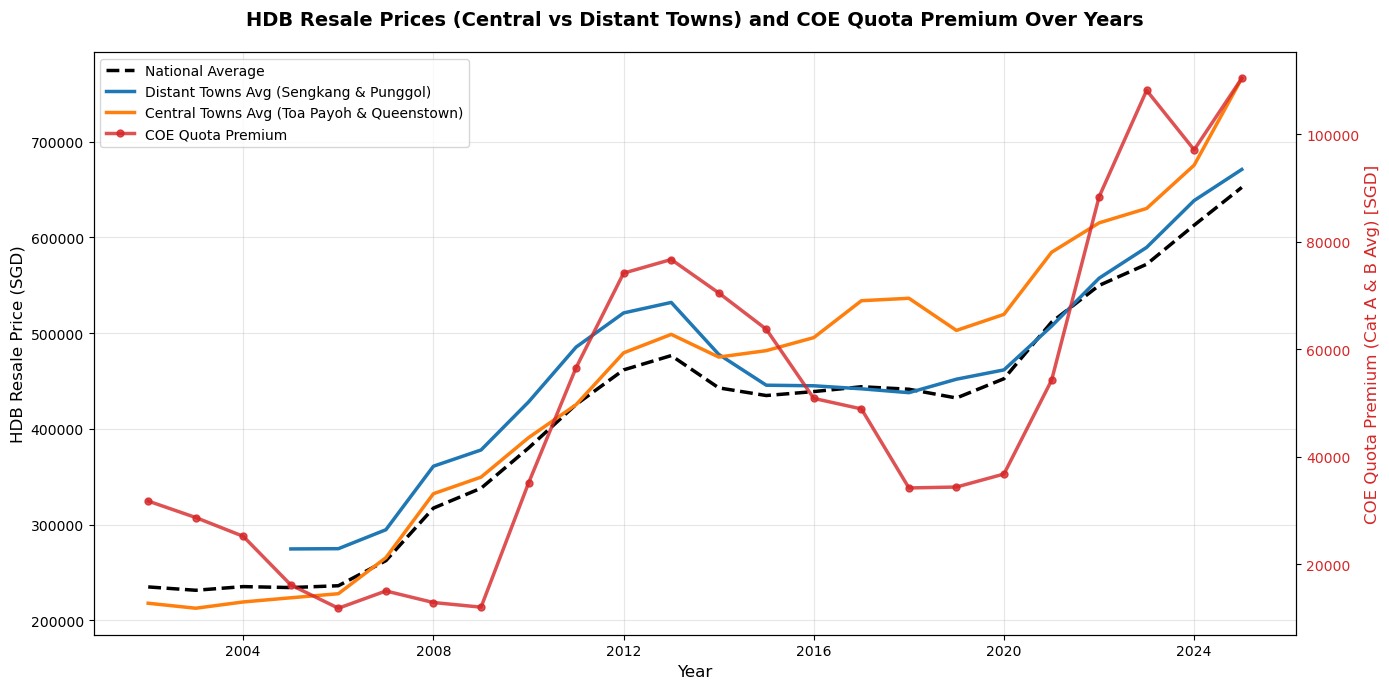

In [13]:
# Calculate average prices for distant and central towns
distant_avg = pd.merge(sengkang_avg[['Year', 'resale_price']], 
                       punggol_avg[['Year', 'resale_price']], 
                       on='Year', suffixes=('_sk', '_pg'))
distant_avg['avg_distant'] = (distant_avg['resale_price_sk'] + distant_avg['resale_price_pg']) / 2

central_avg = pd.merge(toa_payoh_avg[['Year', 'resale_price']], 
                       queenstown_avg[['Year', 'resale_price']], 
                       on='Year', suffixes=('_tp', '_qt'))
central_avg['avg_central'] = (central_avg['resale_price_tp'] + central_avg['resale_price_qt']) / 2

# Create figure with dual y-axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot HDB prices on left y-axis
color_national = 'black'
color_distant = 'tab:blue'
color_central = 'tab:orange'

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('HDB Resale Price (SGD)', fontsize=12)

# Plot lines
line1 = ax1.plot(hdb_avg['Year'], hdb_avg['resale_price'], 
                 label='National Average', linewidth=2.5, color=color_national, linestyle='--')
line2 = ax1.plot(distant_avg['Year'], distant_avg['avg_distant'], 
                 label='Distant Towns Avg (Sengkang & Punggol)', linewidth=2.5, color=color_distant)
line3 = ax1.plot(central_avg['Year'], central_avg['avg_central'], 
                 label='Central Towns Avg (Toa Payoh & Queenstown)', linewidth=2.5, color=color_central)

ax1.tick_params(axis='y')
ax1.grid(True, alpha=0.3)

# Create second y-axis for COE
ax2 = ax1.twinx()
color_coe = 'tab:red'
ax2.set_ylabel('COE Quota Premium (Cat A & B Avg) [SGD]', color=color_coe, fontsize=12)
line4 = ax2.plot(coe_avg['Year'], coe_avg['Quota Premium'], 
                 color=color_coe, linewidth=2.5, marker='o', markersize=5, 
                 label='COE Quota Premium', alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color_coe)

# Add title
plt.title('HDB Resale Prices (Central vs Distant Towns) and COE Quota Premium Over Years', 
          fontsize=14, fontweight='bold', pad=20)

# Combine legends from both axes
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig("figures/hdb_prices_overlaid_car_coe.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Calculating correlation between hdb prices and coe prices

In [14]:
sengkang_coe = pd.merge(sengkang_avg, coe_avg, on='Year', how='inner')
punggol_coe = pd.merge(punggol_avg, coe_avg, on='Year', how='inner')
toa_payoh_coe = pd.merge(toa_payoh_avg, coe_avg, on='Year', how='inner')
queenstown_coe = pd.merge(queenstown_avg, coe_avg, on='Year', how='inner')

In [15]:
# Calculate correlations
corr_sengkang = sengkang_coe['resale_price'].corr(sengkang_coe['Quota Premium'])
corr_punggol = punggol_coe['resale_price'].corr(punggol_coe['Quota Premium'])
corr_toa_payoh = toa_payoh_coe['resale_price'].corr(toa_payoh_coe['Quota Premium'])
corr_queenstown = queenstown_coe['resale_price'].corr(queenstown_coe['Quota Premium'])



In [16]:
# Display results
print("Correlation between COE Quota Premium and HDB Resale Prices:")
print(f"SENGKANG (Distant):     {corr_sengkang:.4f}")
print(f"PUNGGOL (Distant):      {corr_punggol:.4f}")
print(f"TOA PAYOH (Central):    {corr_toa_payoh:.4f}")
print(f"QUEENSTOWN (Central):   {corr_queenstown:.4f}")
print("\n")

# Calculate average for distant vs central
avg_distant = (corr_sengkang + corr_punggol) / 2
avg_central = (corr_toa_payoh + corr_queenstown) / 2

print(f"Average Distant Towns:  {avg_distant:.4f}")
print(f"Average Central Towns:  {avg_central:.4f}")
print(f"Difference (Central - Distant): {avg_central - avg_distant:.4f}")

Correlation between COE Quota Premium and HDB Resale Prices:
SENGKANG (Distant):     0.9013
PUNGGOL (Distant):      0.9255
TOA PAYOH (Central):    0.8564
QUEENSTOWN (Central):   0.7995


Average Distant Towns:  0.9134
Average Central Towns:  0.8279
Difference (Central - Distant): -0.0855


# Note
hdb prices and coe, both increase over time. The correlation between the two is strong but that does not mean coe prices drive hdb flat prices, there are many other factors at play.

To visualise the effect of coe prices of hdb price, we might look at % change in prices with time.

# Correlation between Percentage change in prices  of hdb and coe

In [17]:
# Calculate year-over-year percentage change for each town
sengkang_avg['price_change_pct'] = sengkang_avg['resale_price'].pct_change() * 100
punggol_avg['price_change_pct'] = punggol_avg['resale_price'].pct_change() * 100
toa_payoh_avg['price_change_pct'] = toa_payoh_avg['resale_price'].pct_change() * 100
queenstown_avg['price_change_pct'] = queenstown_avg['resale_price'].pct_change() * 100

# Calculate year-over-year percentage change for COE
coe_avg['coe_change_pct'] = coe_avg['Quota Premium'].pct_change() * 100

# Merge and calculate correlations (drop first row due to NaN from pct_change)
sengkang_coe_change = pd.merge(sengkang_avg[['Year', 'price_change_pct']], 
                                coe_avg[['Year', 'coe_change_pct']], 
                                on='Year', how='inner').dropna()

punggol_coe_change = pd.merge(punggol_avg[['Year', 'price_change_pct']], 
                               coe_avg[['Year', 'coe_change_pct']], 
                               on='Year', how='inner').dropna()

toa_payoh_coe_change = pd.merge(toa_payoh_avg[['Year', 'price_change_pct']], 
                                 coe_avg[['Year', 'coe_change_pct']], 
                                 on='Year', how='inner').dropna()

queenstown_coe_change = pd.merge(queenstown_avg[['Year', 'price_change_pct']], 
                                  coe_avg[['Year', 'coe_change_pct']], 
                                  on='Year', how='inner').dropna()

# Calculate correlations on percentage changes
corr_sengkang_change = sengkang_coe_change['price_change_pct'].corr(sengkang_coe_change['coe_change_pct'])
corr_punggol_change = punggol_coe_change['price_change_pct'].corr(punggol_coe_change['coe_change_pct'])
corr_toa_payoh_change = toa_payoh_coe_change['price_change_pct'].corr(toa_payoh_coe_change['coe_change_pct'])
corr_queenstown_change = queenstown_coe_change['price_change_pct'].corr(queenstown_coe_change['coe_change_pct'])

# Display results
print("Correlation between COE % Change and HDB Resale Price % Change:")
print(f"SENGKANG (Distant):     {corr_sengkang_change:.4f}")
print(f"PUNGGOL (Distant):      {corr_punggol_change:.4f}")
print(f"TOA PAYOH (Central):    {corr_toa_payoh_change:.4f}")
print(f"QUEENSTOWN (Central):   {corr_queenstown_change:.4f}")
print("\n")

avg_distant_change = (corr_sengkang_change + corr_punggol_change) / 2
avg_central_change = (corr_toa_payoh_change + corr_queenstown_change) / 2

print(f"Average Distant Towns:  {avg_distant_change:.4f}")
print(f"Average Central Towns:  {avg_central_change:.4f}")
print(f"Difference (Central - Distant): {avg_central_change - avg_distant_change:.4f}")

Correlation between COE % Change and HDB Resale Price % Change:
SENGKANG (Distant):     0.4743
PUNGGOL (Distant):      0.4435
TOA PAYOH (Central):    0.3247
QUEENSTOWN (Central):   0.2815


Average Distant Towns:  0.4589
Average Central Towns:  0.3031
Difference (Central - Distant): -0.1558


# Takeaway 

1. Moderate Positive Correlations (Not Strong)

All correlations are in the 0.28-0.47 range (moderate, not strong).
This suggests COE changes explain only part of the price variation.
Many other factors are at play (policies, infrastructure, economic conditions).

2. Distant Towns Show STRONGER Correlation

Distant towns: 0.46 average correlation
Central towns: 0.30 average correlation
Difference: -0.16 (distant towns ~50% more correlated)

The Trade-Off Theory Has Some Merit!

Distant town prices ARE more responsive to COE changes than central towns
When COE prices change (up or down), distant town prices react more strongly
This supports the idea that COE affordability does influence demand for distant flats

# Plot price gap between central and distant towns  and COE price across years

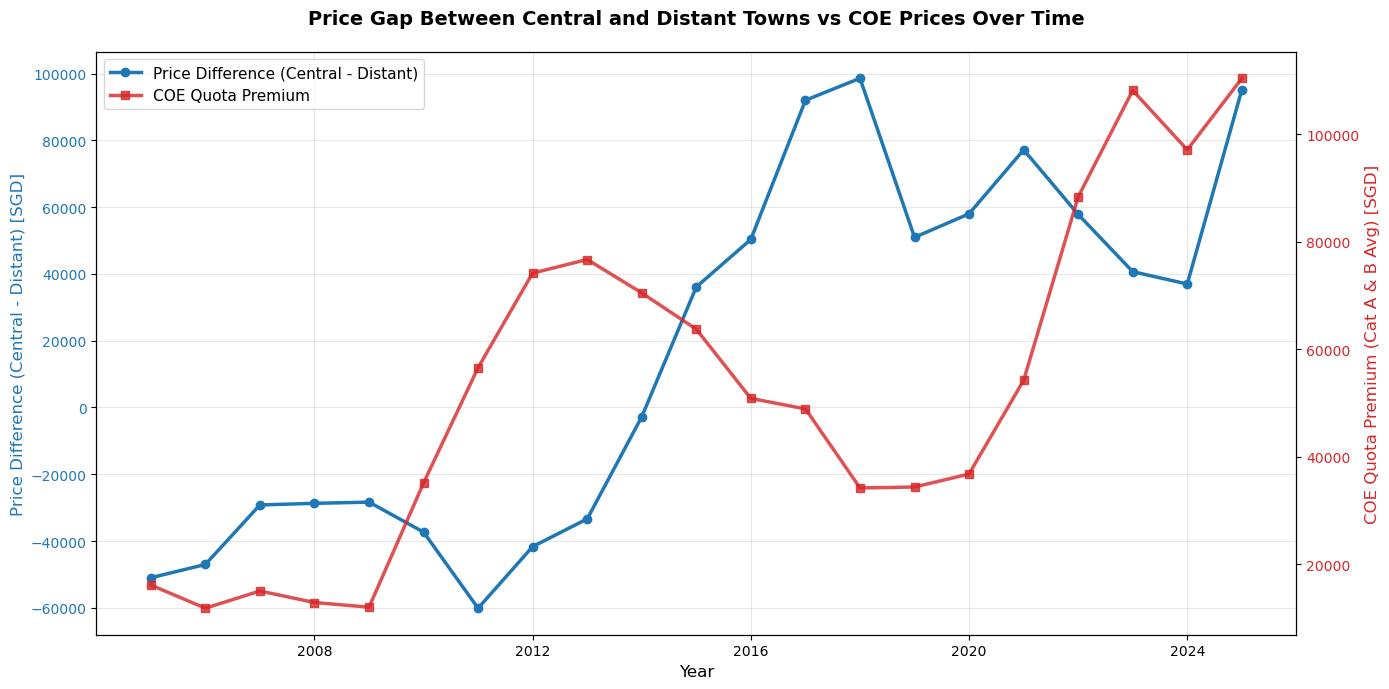


 Overall Correlation between Price Difference (Central-Distant) and COE across 20 years: 0.3971. 


In [18]:
# Calculate average prices for distant and central towns
distant_avg_prices = pd.merge(sengkang_avg[['Year', 'resale_price']], 
                               punggol_avg[['Year', 'resale_price']], 
                               on='Year', suffixes=('_sengkang', '_punggol'))
distant_avg_prices['avg_distant'] = (distant_avg_prices['resale_price_sengkang'] + 
                                      distant_avg_prices['resale_price_punggol']) / 2

central_avg_prices = pd.merge(toa_payoh_avg[['Year', 'resale_price']], 
                               queenstown_avg[['Year', 'resale_price']], 
                               on='Year', suffixes=('_toa_payoh', '_queenstown'))
central_avg_prices['avg_central'] = (central_avg_prices['resale_price_toa_payoh'] + 
                                      central_avg_prices['resale_price_queenstown']) / 2

# Merge to calculate price difference
price_diff = pd.merge(central_avg_prices[['Year', 'avg_central']], 
                      distant_avg_prices[['Year', 'avg_distant']], 
                      on='Year')
price_diff['price_difference'] = price_diff['avg_central'] - price_diff['avg_distant']

# Merge the hdb price diff with COE data
price_diff_coe = pd.merge(price_diff, coe_avg, on='Year', how='inner')

# Create figure with dual y-axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot price difference on left y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Price Difference (Central - Distant) [SGD]', color=color1, fontsize=12)
line1 = ax1.plot(price_diff_coe['Year'], price_diff_coe['price_difference'], 
                 color=color1, linewidth=2.5, marker='o', label='Price Difference (Central - Distant)')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Create second y-axis for COE
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('COE Quota Premium (Cat A & B Avg) [SGD]', color=color2, fontsize=12)
line2 = ax2.plot(price_diff_coe['Year'], price_diff_coe['Quota Premium'], 
                 color=color2, linewidth=2.5, marker='s', label='COE Quota Premium', alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color2)

# Add title
plt.title('Price Gap Between Central and Distant Towns vs COE Prices Over Time', 
          fontsize=14, fontweight='bold', pad=20)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=11)

plt.tight_layout()
plt.savefig("figures/hdb_prices_diff_vs_car_coe.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Print correlation between price difference and COE
corr_diff_coe = price_diff_coe['price_difference'].corr(price_diff_coe['Quota Premium'])
print(f"\n Overall Correlation between Price Difference (Central-Distant) and COE across 20 years: {corr_diff_coe:.4f}. ")

# Take Away
The Trade-Off Theory DOES Have Support!
When we look at the actual dynamics:
Early Period (2006-2010):

Distant towns (Sengkang/Punggol) were actually MORE expensive
Why? New developments, MRT excitement, young families wanting new estates
Low COE = cars affordable for everyone

Transition (2011-2013):

COE skyrockets
Central towns start commanding premium
Gap shifts from negative to positive

Recent Period (2020-2025):

COE at historic highs
But gap has been volatile and recently narrowing
Suggests distant towns catching up when COE is high

### The Correlation between hdb price difference and coe prices  is Misleading (0.3971)
- Both variables trend upward over the long term (20 years)
- This creates a positive correlation even though short-term movements are opposite- 
The correlation captures the long-term trend, not the actual relationship

### Following are further tests to acertain effect of COE prices on prices of distant HDBs

## Linear detrending the time series data 
to remove the long-term increasing trend in prices (that inflate the correlation).


In [19]:
# Detrend HDB prices
years_numeric = (price_diff_coe['Year'] - price_diff_coe['Year'].min()).dt.days
slope_hdb, intercept_hdb, _, _, _ = stats.linregress(years_numeric, price_diff_coe['price_difference'])
trend_hdb = slope_hdb * years_numeric + intercept_hdb
detrended_hdb = price_diff_coe['price_difference'] - trend_hdb

# Detrend COE prices
slope_coe, intercept_coe, _, _, _ = stats.linregress(years_numeric, price_diff_coe['Quota Premium'])
trend_coe = slope_coe * years_numeric + intercept_coe
detrended_coe = price_diff_coe['Quota Premium'] - trend_coe

# Correlate detrended values
corr_detrended = np.corrcoef(detrended_hdb, detrended_coe)[0, 1]
print(f"Detrended correlation: {corr_detrended:.4f}")

Detrended correlation: -0.6547


### Take Away of Detrended correlation test:
There is moderate correlation (-0.65) between hdb price difference  (central and distant town) and coe prices. COE prices somewhat push the distant hdb prices to go up

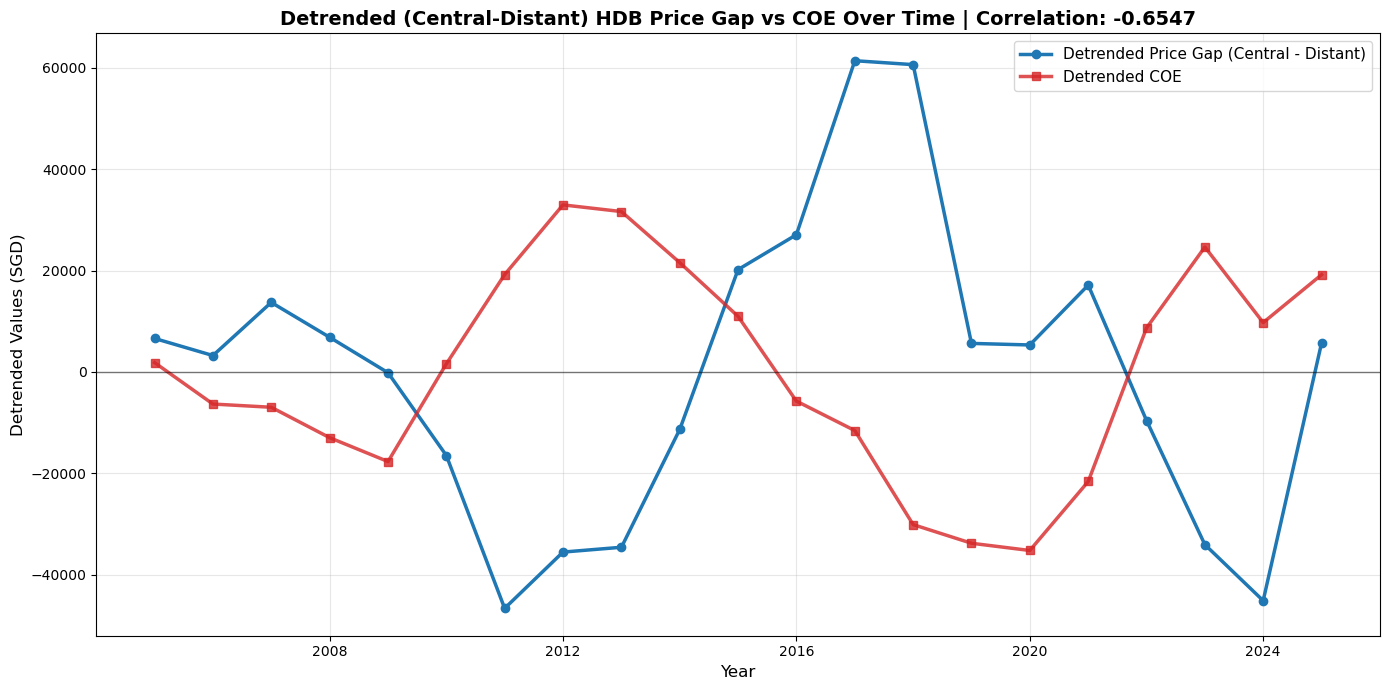

In [22]:

# Plot both detrended series
plt.figure(figsize=(14, 7))

plt.plot(price_diff_coe['Year'], detrended_hdb, 
         'o-', color='tab:blue', linewidth=2.5, label='Detrended Price Gap (Central - Distant)', markersize=6)
plt.plot(price_diff_coe['Year'], detrended_coe, 
         's-', color='tab:red', linewidth=2.5, label='Detrended COE', markersize=6, alpha=0.8)

plt.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Detrended Values (SGD)', fontsize=12)
plt.title(f'Detrended (Central-Distant) HDB Price Gap vs COE Over Time | Correlation: {corr_detrended:.4f}', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("figures/detrended_hdb_prices_diff_vs_car_coe.pdf", dpi=300, bbox_inches='tight')
plt.show()

# The Granger Causality test 
Assesses whether past values of COE (Certificate of Entitlement) prices help predict future changes in your price difference variable, beyond what past values of price difference alone predict.

In [21]:
# Prepare data (needs to be in columns)
data = price_diff_coe[['price_difference', 'Quota Premium']].dropna()

# Test if COE Granger-causes price difference (lags 1-4 years)
print("Does COE Granger-cause price difference?")
grangercausalitytests(data[['price_difference', 'Quota Premium']], maxlag=4, verbose=True)

Does COE Granger-cause price difference?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0030  , p=0.1012  , df_denom=17, df_num=1
ssr based chi2 test:   chi2=3.5330  , p=0.0602  , df=1
likelihood ratio test: chi2=3.2534  , p=0.0713  , df=1
parameter F test:         F=3.0030  , p=0.1012  , df_denom=17, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.8106  , p=0.0053  , df_denom=14, df_num=2
ssr based chi2 test:   chi2=21.2001 , p=0.0000  , df=2
likelihood ratio test: chi2=14.2392 , p=0.0008  , df=2
parameter F test:         F=7.8106  , p=0.0053  , df_denom=14, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.1593  , p=0.0039  , df_denom=11, df_num=3
ssr based chi2 test:   chi2=40.0550 , p=0.0000  , df=3
likelihood ratio test: chi2=21.0783 , p=0.0001  , df=3
parameter F test:         F=8.1593  , p=0.0039  , df_denom=11, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F t

/opt/anaconda3/envs/nus_odi/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(3.003034960854878),
    np.float64(0.10120850974468584),
    np.float64(17.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(3.532982306888092),
    np.float64(0.06015948781925636),
    np.int64(1)),
   'lrtest': (np.float64(3.253413320558991),
    np.float64(0.07127488728198607),
    np.int64(1)),
   'params_ftest': (np.float64(3.0030349609132685),
    np.float64(0.10120850974162189),
    np.float64(17.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(7.810574483478794),
    np.float64(0.005268451034412676),
    np.float64(14.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(21.20013074087101),
    np.float64(2.491438101433154e-05),
    np.int64(2)),
   'lrtest': (np.float64(14.239194105560728),
    np.float64(0.000809092707104929),
    np.int64(2)),
   'params_ftest': (np.float64(7.810574483478786),
    np.float64(0.005268451034412698),
    np.float64(14.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
   

# Conclusion of Granger test: 
COE price changes can somewhat help forecast price difference trends, especially with a lag of 2, 3, or 4 years, suggesting a delayed effect rather than immediate causality.